In [1]:
import math
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.optimize import root_scalar
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import numpy as np
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
import pandas
import timeit
from pyro.infer.mcmc import MCMC, HMC, NUTS


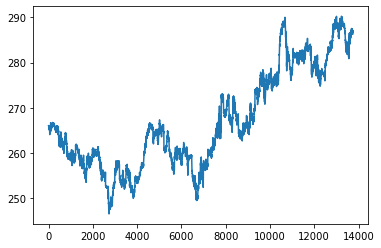

In [2]:
data=pandas.read_csv("MSFT.csv")
plt.plot(data["open"])
data=np.flip(data["open"].to_numpy())[:13500]
#plt.plot([i for i in range(len(data))],data)
plt.savefig("img.png",dpi=900)


In [3]:
def approxmu(data):
    deltat=1/(505)
    s=0
    for i in range(1,len(data)):
        s=s+data[i]/data[i-1]-1
    s=s/(len(data)*deltat)
    return s

In [4]:
def approxsigma(data):
    mu=approxmu(data)
    deltat=1/(505)
    s=0
    for i in range(1,len(data)):
        s=s+(data[i]/data[i-1]-1-mu*deltat)**2/deltat
    s=math.sqrt(s)/(math.sqrt(len(data)))
    return s

In [5]:
print("Approx mu is", approxmu(data))
print("Approx sigma is", approxsigma(data))

Approx mu is -0.0024025781957533123
Approx sigma is 0.02490237861448845


In [6]:
def realk(data):
    deltat=1/(505)
    return (math.log(data[len(data)-1])-math.log(data[0]))/(len(data)*deltat)

In [7]:
def realsigma(data):
    k=realk(data)
    temp0=0
    deltat=1/(505)
    for i in range(1,len(data)):
        temp0=temp0+(math.log(data[i])-math.log(data[i-1])-k*deltat)**2
    s=math.sqrt(temp0)/math.sqrt(len(data)*deltat)
    return s

In [8]:
def realmu(data):
    return realk(data)+realsigma(data)**2/2


In [9]:
print("Approx mu is", approxmu(data))
print("Approx sigma is", approxsigma(data))
print("Real mu is", realmu(data))
print("Real sigma is", realsigma(data))

Approx mu is -0.0024025781957533123
Approx sigma is 0.02490237861448845
Real mu is -0.002402554985817001
Real sigma is 0.02490590039329626


In [10]:
def cevsolution(data):
    deltat=1/505
    def sigmafunc(mu,gamma):
        temp0=0
        for i in range(1,len(data)):
            temp0=temp0+(data[i]/data[i-1]**gamma-data[i-1]**(1-gamma)*(1+mu*deltat))**2/deltat
        return math.sqrt(temp0)/math.sqrt(len(data))
    def mufunc(gamma):
        temp0=0
        temp1=0
        for i in range(1,len(data)):
            temp0=temp0+(data[i]/(data[i-1]**(2*gamma-1)))-data[i-1]**(2-2*gamma)
            temp1=temp1+data[i-1]**(2-2*gamma)
        return (temp0/temp1)*(1/deltat)
    def gammafunc(mu,sigma,gamma):
        temp0=0
        temp1=0
        for i in range(1,len(data)):
            temp0=temp0-math.log(data[i-1])
            temp1=temp1+(((1+mu*deltat)*data[i-1]-data[i])**2)*math.log(data[i-1])/(data[i-1]**(2*gamma)*sigma**2*deltat)
        return temp0+temp1
    def func(x):
        mu=mufunc(x)
        sigma=sigmafunc(mu,x)
        gamma=gammafunc(mu,sigma,x)
        return gamma
    gamma=root_scalar(func,bracket=[0,20]).root
    mu=mufunc(gamma)
    sigma=sigmafunc(mu,gamma)
    return mu,sigma,gamma
    
        
                         
                         

In [11]:
mu,sigma,gamma=cevsolution(data)
print("CEV mu is", mu)
print("CEV sigma is", sigma)
print("CEV gamma is", gamma)
data=torch.tensor(data.copy(),dtype=torch.float64)

CEV mu is -0.0024547298130310033
CEV sigma is 0.03568916672032402
CEV gamma is 0.9355761055580047


In [14]:
def approxmu_torch(data):
    deltat=torch.tensor(1/(505))
    s=0
    for i in range(1,data.shape[0]):
        s=s+data[i]/data[i-1]-1
    s=s/(data.shape[0]*deltat)
    return s

def heston(data):
    pyro.set_rng_seed(2022)
    data=data
    deltat=torch.tensor(1/(505))
    def model(data):
        xi=pyro.sample("xi", dist.Normal(0,10000))
        theta=pyro.sample("theta", dist.Normal(0,10000))
        #enforces Feller condition
        kappa=xi**2/(2*theta)+1
        mu=approxmu_torch(data)
        s=data[0]
        nu=torch.tensor(6.)
        for i in pyro.plate("observed data",data.shape[0]):
            mus=(1+mu*deltat)*s
            sigmas=torch.sqrt(nu)*s**2*torch.sqrt(deltat)
            munu=kappa*(theta-nu)*deltat+nu
            sigmanu=xi*torch.sqrt(nu)*2*torch.sqrt(deltat)
            s=pyro.sample("s_{}".format(i),dist.Normal(mus,sigmas) ,obs=data[i])
            nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
    
    nuts=NUTS(model,jit_compile=True)
    mcmc=MCMC(nuts,warmup_steps=1000,num_samples=500,num_chains=1)
    posterior = mcmc.run(data)
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    xi = mcmc_samples["theta1"]
    theta2 = mcmc_samples["theta2"]
    print("Heston mu is", mu.item())
    print("Heston k is", k.item())
    print("Heston theta is", theta.item())
    print("Heston xi is", xi.item())                 

In [ ]:
heston(data)

Warmup:   0%|                                            | 0/1500 [00:00, ?it/s]/tmp/ipykernel_28791/431323167.py:2: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  deltat=torch.tensor(1/(505))
/tmp/ipykernel_28791/431323167.py:20: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.tensor(6.)
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Pas

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning:

/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You

/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  yield i if isinstance(i, numbers.Number) else i.item()
/tmp/ipykernel_28791/431323167.py:27: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  nu=torch.max(pyro.sample("nu_{}".format(i),dist.Normal(munu,sigmanu)),torch.tensor(0.0001,dtype=torch.float64))
/home/cyberguli/.conda/envs/progettopml/lib/python3.9/site-packages/pyro/poutine/indep_messenger.py:111: TracerWarning: